# CNN Keras - Hyperparameter Optimization Tutorial [W&B Part 2]


### Weights & Biases (W&B)

### 01/08/2020


### [See Part 1 of the notebook series on how to keep tracking of your experiments with W&B](https://www.kaggle.com/imeintanis/tutorial-cnn-keras-experiment-tracking-w-b-p1?scriptVersionId=40015533)

# Introduction 

This a series of tutorial notebooks devoted to CNN modelling, experiment tracking and hyperparameter optimization using Weights and Biases (W&B). To my knowledge there are many awsome pipelines here in kaggle for hyperparameter optimisation using Bayesian opt., random/grid search etc, but not with W&B. So I decided to make a step-by-step guide on how to use this tool in kaggle.

As an example I use the famous digits recognition problem (MNIST dataset) and a simple CNN model [Keras TF]. After the standard data loading and preprocessing routines I will focus on the CNN model and how to build the configuration for the hyperparameter tuning.

In [ ]:
!pip install --upgrade wandb

In [ ]:
import os 
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import gc

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *

import tensorflow_addons as tfa

import wandb
from wandb.keras import WandbCallback

## Helpers

In [ ]:
# Load the data
def load_data(path):

    train = pd.read_csv(path+"train.csv")
    test = pd.read_csv(path+"test.csv")
    
    x_tr = train.drop(labels=["label"], axis=1)
    y_tr = train["label"]
    
    print(f'Train: we have {x_tr.shape[0]} images with {x_tr.shape[1]} features and {y_tr.nunique()} classes')
    print(f'Test: we have {test.shape[0]} images with {test.shape[1]} features')
    
    return x_tr, y_tr, test


def seed_all(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

# CNN Model

#### Architecture 1 - a simple CNN architecture build with the Keras Functional API (TF backend). The main building blocks and their usage are:

- Convolutional (Conv2D) layer: It is like a set of learnable filters. I choosed to set 32 filters for the first two layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image. The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

- Pooling (MaxPool2D) layer: This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

- Dropout: is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

- Activation function: 'relu' is the rectifier activation function, used to add non linearity to the model.

- Flatten layer: is used to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

- Fully-Connected (Dense) layers: to act as a (NN) classifier. Note that in the last layer (Dense(10,activation="softmax")) the net outputs distribution of probability of each class.


#### Architecture 2 - LeNet5 with some tweaks by C.Deotte (see credits)

In [ ]:
# Build CNN model 
# CNN architechture: In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

def build_model(config):
    
    fs = config.filters         # 32
    k1 = config.kernel_1        #[(5,5), (3,3)]
    k2 = config.kernel_2        # [(5,5), (3,3)]
    pad = config.padding
    activ = config.activation   # 'relu'
    pool = config.pooling       # (2,2)
    dp = config.dropout         # 0.25
    dp_out = config.dropout_f   # 0.5
    dense_units = config.dense_units  # 256
    batch_norm = True
    
    inp = Input(shape=(28,28,1))    # IMG_H, IMG_W, NO_CHANNELS
    
    # layer-1:: CNN-CNN-(BN)-Pool-dp
    x = Conv2D(filters=fs, kernel_size=k1, padding=pad, activation=activ)(inp)
    x = Conv2D(filters=fs, kernel_size=k1, padding=pad, activation=activ)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dp)(x)    
    
    # layer-2:: CNN-CNN-(BN)-Pool-dp
    x = Conv2D(filters=fs*2, kernel_size=k2, padding=pad, activation=activ)(inp)
    x = Conv2D(filters=fs*2, kernel_size=k2, padding=pad, activation=activ)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
    x = Dropout(dp)(x)  
    
    x = Flatten()(x)
    #     x = GlobalAveragePooling2D()(x)
    
    # FC head
    x = Dense(dense_units, activation=activ)(x)
    x = Dropout(dp_out)(x)
    
    out = Dense(10, activation="softmax")(x)
    
    model = tf.keras.models.Model(inp, out)
    
    print(model.summary())
    return model

In [ ]:
def build_lenet(config):
    
    fs = config.filters       # 32     
    k1 = config.kernel_1      # 3  
    k2 = config.kernel_2          
    pad = config.padding
    activ = config.activation     
    dp = config.dropout           
    
    inp = Input(shape=(28,28,1))  # (IMG_H, IMG_W, NO_CHANNELS)
    
    x = Conv2D(fs, kernel_size = k1, activation=activ)(inp)
    x = BatchNormalization()(x)
    x = Conv2D(fs, kernel_size = k1, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs, kernel_size = 5, strides=2, padding='same', activation=activ)(x)
    x = BatchNormalization()(x)
    x = Dropout(dp)(x)
    
    x = Conv2D(fs*2, kernel_size = k1, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs*2, kernel_size = k1, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs*2, kernel_size = 5, strides=2, padding='same', activation=activ)(x)
    x = BatchNormalization()(x)
    x = Dropout(dp)(x)
    
    x = Conv2D(fs*4, kernel_size = 4, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(dp)(x)
    
    out = Dense(10, activation='softmax')(x)
    
    model = tf.keras.models.Model(inp, out)

    print(model.summary())
    return model

## Master Params

I use the master variable DEBUG to control the no. of epochs per trial and hence the runtime of the commit.

- set `DEBUG = True` in case of setup/testing/debugging

- set `DEBUG = False` when you ready to run experiments

In [ ]:
DEBUG = False          # set to True in case of setup/testing/debugging -- False when you ready to run experiments
# DATA_AUGM = False   # set to True if you wish to add data augmentation 

BATCH_SIZE = 64

if DEBUG:
    EPOCHS = 3          
else: 
    EPOCHS = 40

# Configure WandB


### 1. First go to the Weights & Biases webpage and register (if you don't have an account yet) or sign-in

### 2. Make a New Project (or go to an existing one if you already have)

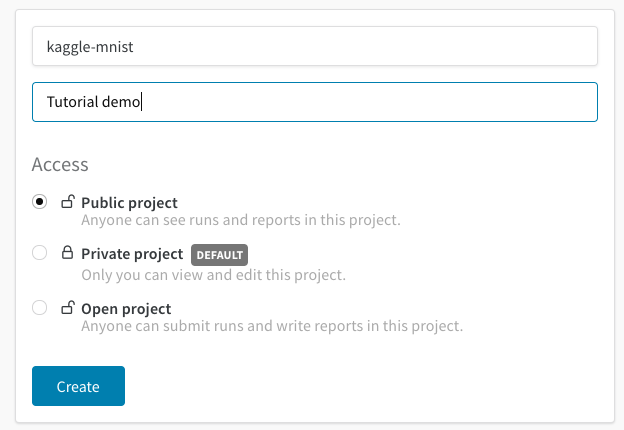

Note: I've chosen a public access project for demonstration reasons - you can keep yours private if you prefer! 

### 3. Select a framework to start working on..


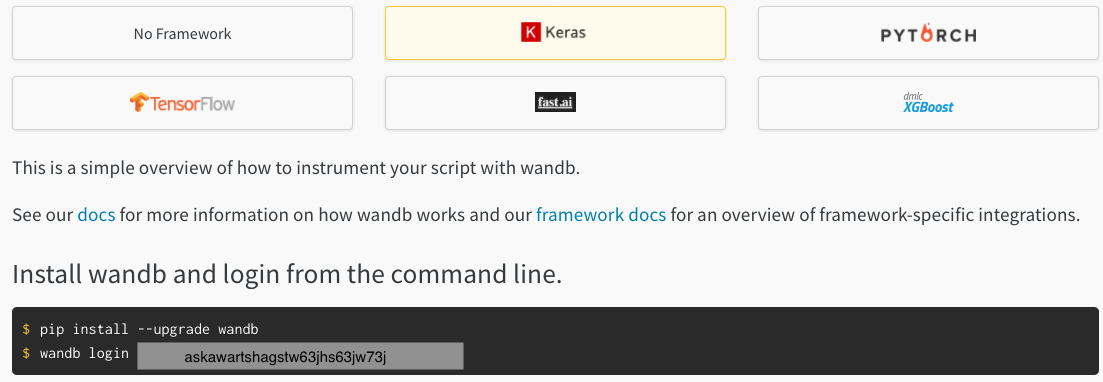


Note: Keep aside your username and login token (API key)

### 4. Login to W&B

From the command line or inside a nb cell run `!wandb login <your_API_key>` to login and initiate W&B

or, use the `wandb.login()` function and copy and paste the API key when asked

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("API_key")

In [ ]:
!wandb login $api_key

### 5. Create the W&B configuration

Let's make a dictionary with all the hyperparameters that we'd like to track! For CNN type models I usually keep track of the following params:

- filters
- kernel size
- learning rate (init)
- optimizer
- dense units
- dropout rate etc

But you can add as many others you like.

In [ ]:
# hyperparams = dict(
#      filters = 32,
#      kernel_1 = (5,5),
#      kernel_2 = (3,3),
#      padding = 'same',
#      pooling = (2,2),
#      lr = 0.001,
#      wd = 0.0,
#      lr_schedule = 'RLR',    # cos, cyclic, step decay
#      optimizer = 'Adam',     # RMS
#      dense_units=256,
#      activation='relu',      # elu, LeakyRelu
#      dropout = 0.25,
#      dropout_f = 0.5,
#      batch_size = BATCH_SIZE,
#      epochs = EPOCHS,
#  )

# wandb.init(project="kaggle-titanic", config=hyperparams)
# config = wandb.config

Next, we need to put in a single function all the modelling pipeline, i.e.

- the data loading,
- preprocessing,
- model building and
- training parts

In [ ]:
def train():
    
    
    hyperparams = dict(
        filters=32,
        kernel_1=(5,5),
        kernel_2=(3,3),
        padding='same',
        pooling=(2,2),
        lr=0.001,
        wd=0.0,
        lr_schedule='RLR',    # cos, cyclic, step decay
        optimizer='Adam',     # 'RMS'
        dense_units=256,
        activation='relu',      # elu, LeakyRelu
        dropout=0.25,
        dropout_f=0.5,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS)
    
    wandb.init(project="kaggle-mnist", config=hyperparams)
    config = wandb.config
    
    
    SEED = 26
    seed_all(SEED)
    
    #     # Define image sizes and reshape to a 3-dim tensor
    #     global
    IMG_H, IMG_W = 28, 28
    NO_CHANNELS = 1           # for greyscale images
    
    # load data
    x_train, y_train, x_test = load_data(path="../input/digit-recognizer/")
    
    
    # Normalize the data
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Reshape to a 4-dim tensor
    x_train = x_train.values.reshape(-1, IMG_H, IMG_W, NO_CHANNELS)
    x_test = x_test.values.reshape(-1, IMG_H, IMG_W, NO_CHANNELS)
    
    # Encode labels
    y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=10)

    print('Tensor shape (train): ', x_train.shape)
    print('Tensor shape (test): ', x_test.shape)
    print('Tensor shape (target ohe): ', y_train_ohe.shape)
    
    # Split the train and the validation set for the fitting
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_ohe, test_size=0.15, random_state=SEED)
    
    print('Tensors shape (train):', x_tr.shape, y_tr.shape)
    print('Tensors shape (valid):', x_val.shape, y_val.shape)
    
    print('Build architecture 1')
    model = build_model(config=config)
    
#     print('Build architecture 2 - LeNet5')
#     model = build_lenet(config=config)
    
    
    # Define the optimizer
    if config.optimizer=='Adam':
        opt = Adam(config.lr)
    elif config.optimizer=='RMS':
        opt = RMSprop(lr=config.lr, rho=0.9, epsilon=1e-08, decay=0.0)
    elif config.optimizer=='Adam+SWA':
        opt = Adam(LR)
        opt = tfa.optimizers.SWA(opt)
    else: 
        opt = 'adam'    # native adam optimizer 
    
    
    # Compile the model
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Set callbacks

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, verbose=1), 
        ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose=1, factor=0.5, min_lr=1e-4),
        WandbCallback(monitor='val_loss', validation_data=(x_val, y_val))]  
    
    model.fit(x_train, y_train_ohe, 
                     batch_size=config.batch_size,    # BATCH_SIZE, 
                     epochs=config.epochs,            # EPOCHS, 
                     validation_data=(x_val, y_val), 
                     callbacks=callbacks,
                     verbose=1) 

# Hyperparameter Optimization


### Method 1

Build the sweep (hyperparameter search) configuration with python dict.

The sweeps config can be defined as a dictionary or a YAML file. Let's walk through some of them together:

- `Metric` – This is the metric the sweeps are attempting to optimize. Metrics can take a name (this metric should be logged by your training script) and a goal (maximize or minimize).

- `Search Strategy` – Specified using the 'method' variable. We support several different search strategies with sweeps.

    - `Grid Search` – Iterates over every combination of hyperparameter values.
    - `Random Search` – Iterates over randomly chosen combinations of hyperparameter values.
    - `Bayesian Search` – Creates a probabilistic model that maps hyperparameters to probability of a metric score, and chooses parameters with high probability of improving the metric. The objective of Bayesian optimization is to spend more time in picking the hyperparameter values, but in doing so trying out fewer hyperparameter values.
    - `Stopping Criteria` – The strategy for determining when to kill off poorly peforming runs, and try more combinations faster. We offer several custom scheduling algorithms like HyperBand and Envelope.

- `Parameters` – A dictionary containing the hyperparameter names, and discreet values, max and min values or distributions from which to pull their values to sweep over.

In [ ]:
sweep_config = {
#     'program': 'train.py',      # 'tutorial-cnn-keras-hyperparameter-opt-w-b-p2.ipynb',
    'method': 'random',           # 'grid', 'hyperopt', 'bayesian'
    'metric': {
        'name': 'val_accuracy',   # or 'val_loss'
        'goal': 'maximize'      
    },
    'parameters': {
        'filters': {
            'values': [16, 32, 64]
        },
        'lr': {
            'distribution': 'uniform',
            'min': 0.0005,
            'max': 0.002
        },
        'dp': {
            'values': [0.4, 0.5]
        }
    }
}

Initialize the sweep by running `wandb.sweep()`. This returns the `sweep_id` that we use to run the sweep agent.

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="ime", project='kaggle-mnist')

Start the agent running with `wandb.agent()`

(here, I limit the number of trial runs using the `count` arg)

In [ ]:
wandb.agent(sweep_id, function=train, count=3, project='kaggle-mnist')   #

In [ ]:
# !wandb agent ime/kaggle-mnist/jp5i153v --count 3 -p 'kaggle-mnist'

When the agent finishes all the trial runs you should be able to visualize the results in the wandb dashboard, e.g.

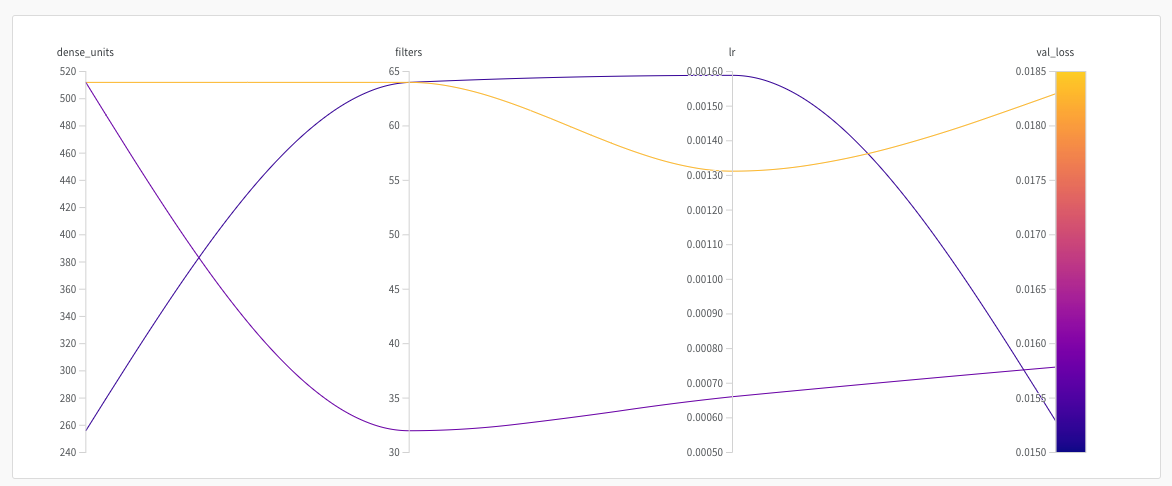

### Method-2

Another easy way to start the configuration for the hyperparameter optimization (sweep) is to use directly the UI:

1. go to the Table format
2. select some runs (at least one)
3. press Create Sweep (by clicking the vertical dots, as seen below)


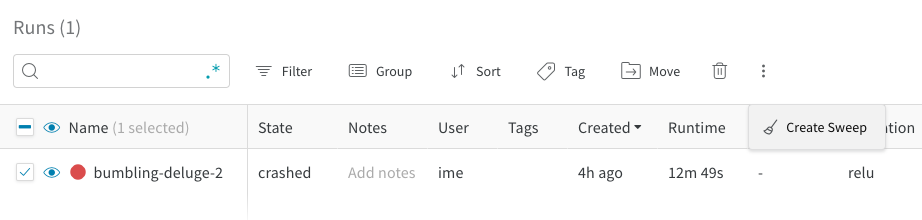

4. This will open a new page where we can setup our Sweep configuration. Change this `.yaml` file accordingly - as before we need to define a `method`, a `metric and goal` and `a list of parameters`

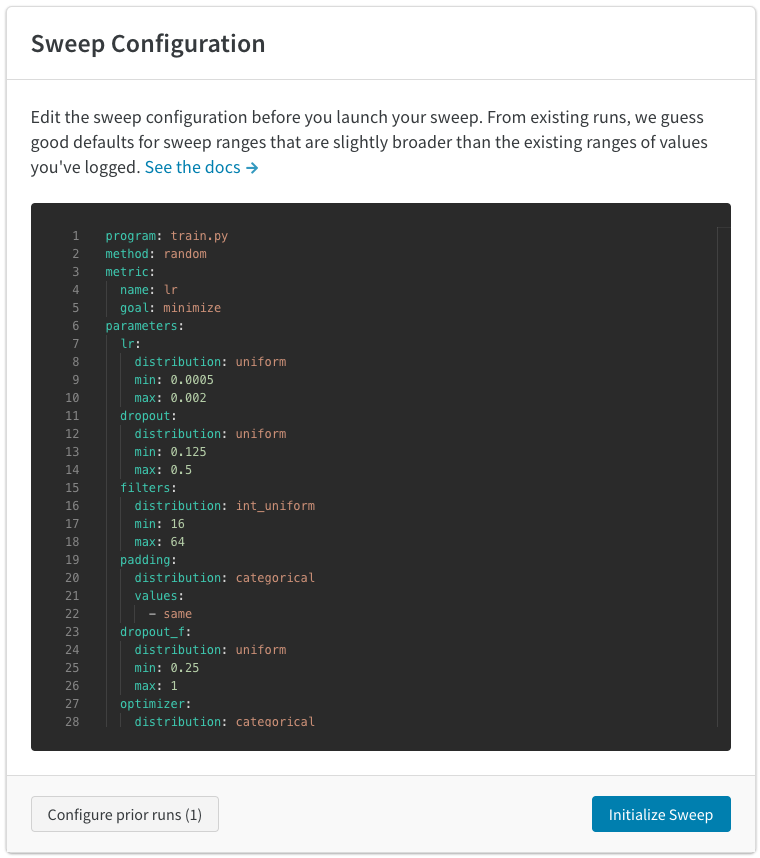

5. Now we are ready to start the Sweep

    - press Initialize Sweep

    - run `wandb agent project/sweep_id` to start the agent running in our machine (Kaggle here..)

Some optional arguments

`--count`: limits the number of total runs, I put a limit of 5 here for demonstration reasons

`-p`: project name

`-e`: entity/user name

In [ ]:
# !wandb agent ime/kaggle-mnist/nkf2bmi7 --count 5 -p kaggle-mnist -e ime

# Resources

- W&B tutorial: https://www.kaggle.com/lavanyashukla01/better-models-faster-with-weights-biases/notebook
- W&B docs sweep: https://docs.wandb.com/sweeps/python-api

## Inspiring kernels

- Chriss Deotte - [25 Million Images! [0.99757] MNIST](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist#Train-15-CNNs)

- Yassine Ghouzam - [introduction-to-cnn-keras-0-997-top-6](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

### Please if you find usefull this notebook upvote it so as to keep the motive to share more! :)

### Fork the notebook 
   - ### setup your config 
   - ### change `DEBUG=False`  
   - ### set the no of trials, and 

### start experimenting with hyperparameter search!

### Please, if you fork - don't forget to upvote too!!